# CREDIT ANALYSIS PROJECT


## This Project has the purporse to analyse customers who want to apply for a loan.

## The goal is to predict who can or not receive a loan using machine learning model. 


# CRISP-DM METHODOLOGY - Cross Industry Standard Process for Data Mining

### CRISP-DM is a data mining methodology in cyclic format, which guide the discovery of knowledge for decision making on large volume data.

In [1]:
Image("img/crisp1.jpg")

NameError: name 'Image' is not defined

# 0.0 IMPORTS

In [578]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import pickle
import imblearn
import keras
import random

from IPython.display         import Image
from IPython.core.display    import HTML
from scipy                   import stats as ss
from datetime                import timedelta
from boruta                  import BorutaPy
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.impute          import SimpleImputer
from sklearn.ensemble        import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.tree            import DecisionTreeClassifier
from sklearn.metrics         import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes     import GaussianNB
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.neural_network  import MLPClassifier
from keras.models            import Sequential
from keras.layers            import Dense
from xgboost                 import XGBClassifier, XGBRFClassifier
from imblearn.over_sampling  import SMOTE


# warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [520]:
def mean_percentage_error(y, yhat):
    return np.mean( ( y-yhat ) / y )

def mean_absolute_percentage_error(y, yhat):
    return np.mean( np.abs( ( y-yhat ) / y ) )

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt(mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name' : model_name,
                           'MAE' : mae,
                           'MAPE' : mape,
                           'RMSE' : rmse }, index=[0] )

def cramer_v(x, y):
    cm = pd.crosstab(x,y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2_corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    k_corr = k - (k-1)**2/(n-1)
    r_corr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2_corr/n) / ( min( k_corr-1, r_corr-1) ) )


def udf_cross_validation(df_train, y_train, model_name, model, n_splits, n_repeats, verbose=False):
    # Transform training dataframe to list
    X_train = df_train.values
    #print(X_train.shape)

    rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=0)
    i=1
    accuracy = []
    conf_matrix = []
    for train_idx, validation_idx in rskf.split(X_train, y_train ): #np.zeros(shape=(X_train.shape[0], 1))
        if verbose:
            print('\n KFold '+str(i))
            #print(train_idx, validation_idx)

        # training model
        model.fit(X_train[train_idx], y_train[train_idx])

        # predicting
        y_pred = model.predict(X_train[validation_idx])
        score = accuracy_score(y_train[validation_idx], y_pred)
        conf_matrix.append( confusion_matrix(y_train[validation_idx], y_pred) ) 
        accuracy.append(score)
        # 
        i+=1
        
    print('Confusion matrix:\n{}\n'.format(np.mean(conf_matrix, axis=0)))
    print(classification_report(y_train[validation_idx], y_pred, digits=4))
        
    return pd.DataFrame(
                        {
                         'Model Name'       : model_name,
                         'Accuracy_score'   : np.round( np.mean(accuracy), 2 ).astype(str)
                        },
                        index=[0]
                    )
 

def jupyter_settings():
   %matplotlib inline
   %pylab inline
   plt.style.use( 'bmh' )
   plt.rcParams['figure.figsize'] = [20, 10]
   plt.rcParams['font.size'] = 10
   display( HTML( '<style>.container { width:100% !important; }</style>') )
   pd.options.display.max_columns = None
   pd.options.display.max_rows = None
   pd.set_option( 'display.expand_frame_repr', False )

sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data and check data types

In [4]:
# load data
df0 = pd.read_csv('data/credit_data.csv')

dtypes = df0.dtypes
colnames = dtypes.index
dtypes_list = [i.name for i in dtypes.values] # transform in a list

# create datatypes dictionary
dict_column_types = dict(zip(colnames, dtypes_list))

print('{}\n\n{}'.format(df0.info(), dict_column_types ))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   i#clientid  2000 non-null   int64  
 1   income      2000 non-null   float64
 2   age         1997 non-null   float64
 3   loan        2000 non-null   float64
 4   c#default   2000 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 78.2 KB
None

{'i#clientid': 'int64', 'income': 'float64', 'age': 'float64', 'loan': 'float64', 'c#default': 'int64'}


In [5]:
# show statistics to determine data types
df0.describe().T

,count,mean,std,min,25%,50%,75%,max
i#clientid,2000.0,1000.500000,577.494589,1.00000,500.750000,1000.500000,1500.250000,2000.000000
income,2000.0,45331.600018,14326.327119,20014.48947,32796.459717,45789.117313,57791.281668,69995.685578
age,1997.0,40.807559,13.624469,-52.42328,28.990415,41.317159,52.587040,63.971796
loan,2000.0,4444.369695,3045.410024,1.37763,1939.708847,3974.719419,6432.410625,13766.051239
c#default,2000.0,0.141500,0.348624,0.00000,0.000000,0.000000,0.000000,1.000000


## 0.3 Loading and Change Data Types

### for better performance is necessary to set data types correctly.

- int8 / uint8 : consumes 1 byte of memory, range between -128/127 or 0/255

- bool : consumes 1 byte, true or false

- float16 / int16 / uint16: consumes 2 bytes of memory, range between -32768 and 32767 or 0/65535

- float32 / int32 / uint32 : consumes 4 bytes of memory, range between -2147483648 and 2147483647

- float64 / int64 / uint64: consumes 8 bytes of memory

In [6]:
# Load full data with optimized datatypes

df0 = pd.read_csv('data/credit_data.csv', dtype={'i#clientid': 'uint16', 'income': 'float32', 'age': 'float16', 'loan': 'float16','c#default': 'uint8'} )
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   i#clientid  2000 non-null   uint16 
 1   income      2000 non-null   float32
 2   age         1997 non-null   float16
 3   loan        2000 non-null   float16
 4   c#default   2000 non-null   uint8  
dtypes: float16(2), float32(1), uint16(1), uint8(1)
memory usage: 21.6 KB


# 1.0 DATA PREPROCESSING

In [7]:
df1 = df0.copy()

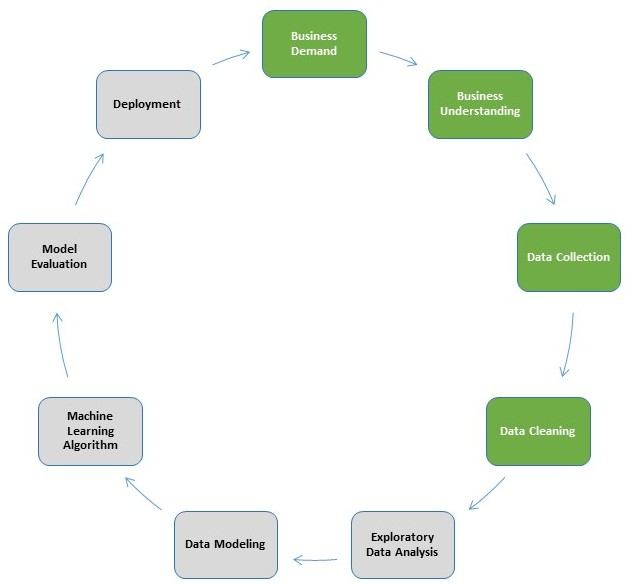

In [8]:
Image("img/crisp3.jpg")

## 1.1 Data Dimensions

In [9]:
df_shape = df1.shape
print('Number of rows: {}\nNumber of Cols: {}'.format(df_shape[0], df_shape[1]))

Number of rows: 2000
Number of Cols: 5


## 1.2 Detecting missing values

In [10]:
# check "not available" values
df1.isna().sum()

i#clientid    0
income        0
age           3
loan          0
c#default     0
dtype: int64

In [11]:
df1.describe()

,i#clientid,income,age,loan,c#default
count,2000.000000,2000.000000,1997.000000,2000.00000,2000.000000
mean,1000.500000,45331.601562,inf,inf,0.141500
std,577.494589,14326.327148,13.625000,inf,0.348624
min,1.000000,20014.490234,-52.437500,1.37793,0.000000
25%,500.750000,32796.460938,28.984375,1940.00000,0.000000
50%,1000.500000,45789.117188,41.312500,3975.00000,0.000000
75%,1500.250000,57791.282227,52.593750,6431.00000,0.000000
max,2000.000000,69995.687500,63.968750,13768.00000,1.000000


## 1.2 Fillout missing values

In [12]:
# filtering only missing values from age
df1[pd.isnull(df1["age"])]



,i#clientid,income,age,loan,c#default
28,29,59417.804688,NaN,2082.0,0
30,31,48528.851562,NaN,6156.0,0
31,32,23526.302734,NaN,2862.0,0


In [13]:
# fillout missing values

# Create object SimpleImputer
si = SimpleImputer(missing_values=np.nan, strategy='mean')

# apply SimpleImputer
si.fit(X=df1)

# reconstruct new dataframe with imputed set
df2 = pd.DataFrame.from_records(
    data=si.transform(
        X=df1
    ),  # SimpleImputer.transform(<<pandas dataframe>>) result is a list of lists
    columns=df1.columns  # keep originals columns
).astype(dtype={'i#clientid': 'uint16', 'income': 'float32', 'age': 'float32', 'loan': 'float32','c#default': 'uint8'})

## 1.3 Treating negative ages

In [14]:
# get mean age>0
age_mean = df2['age'][df2.age>0].mean()

# applying mean to negative ages
df2.loc[df2.age < 0, 'age'] = age_mean
df2.describe()

,i#clientid,income,age,loan,c#default
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1000.500000,45331.601562,40.927483,4444.361816,0.141500
std,577.494589,14326.327148,13.252040,3045.398926,0.348624
min,1.000000,20014.490234,18.062500,1.377930,0.000000
25%,500.750000,32796.460938,29.101562,1940.000000,0.000000
50%,1000.500000,45789.117188,41.296875,3975.000000,0.000000
75%,1500.250000,57791.282227,52.593750,6431.000000,0.000000
max,2000.000000,69995.687500,63.968750,13768.000000,1.000000


# 2.0 DATA DESCRIPTIONS

In [15]:
# create dataframe by data type
num_attributes = df2.select_dtypes( exclude=['object', 'datetime64[ns]', 'category'] )
cat_attributes = df2.select_dtypes( include=['object', 'category'] )

## 2.1 Numerical Attributes Statistics

In [16]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kutosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,i#clientid,1.000000,2000.00000,1999.000000,1000.500000,1000.500000,577.350197,0.000000,-1.200000
1,income,20014.490234,69995.68750,49981.195312,45331.601562,45789.117188,14322.745117,-0.042621,-1.201707
2,age,18.062500,63.96875,45.906250,40.927483,41.296875,13.248727,-0.016806,-1.219131
3,loan,1.377930,13768.00000,13766.622070,4444.361816,3975.000000,3044.637695,0.624265,-0.337414
4,c#default,0.000000,1.00000,1.000000,0.141500,0.000000,0.348537,2.058717,2.240556


In [17]:
df2.dtypes

i#clientid     uint16
income        float32
age           float32
loan          float32
c#default       uint8
dtype: object

In [18]:
df2.describe()

,i#clientid,income,age,loan,c#default
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1000.500000,45331.601562,40.927483,4444.361816,0.141500
std,577.494589,14326.327148,13.252040,3045.398926,0.348624
min,1.000000,20014.490234,18.062500,1.377930,0.000000
25%,500.750000,32796.460938,29.101562,1940.000000,0.000000
50%,1000.500000,45789.117188,41.296875,3975.000000,0.000000
75%,1500.250000,57791.282227,52.593750,6431.000000,0.000000
max,2000.000000,69995.687500,63.968750,13768.000000,1.000000


C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

<AxesSubplot:xlabel='loan'>

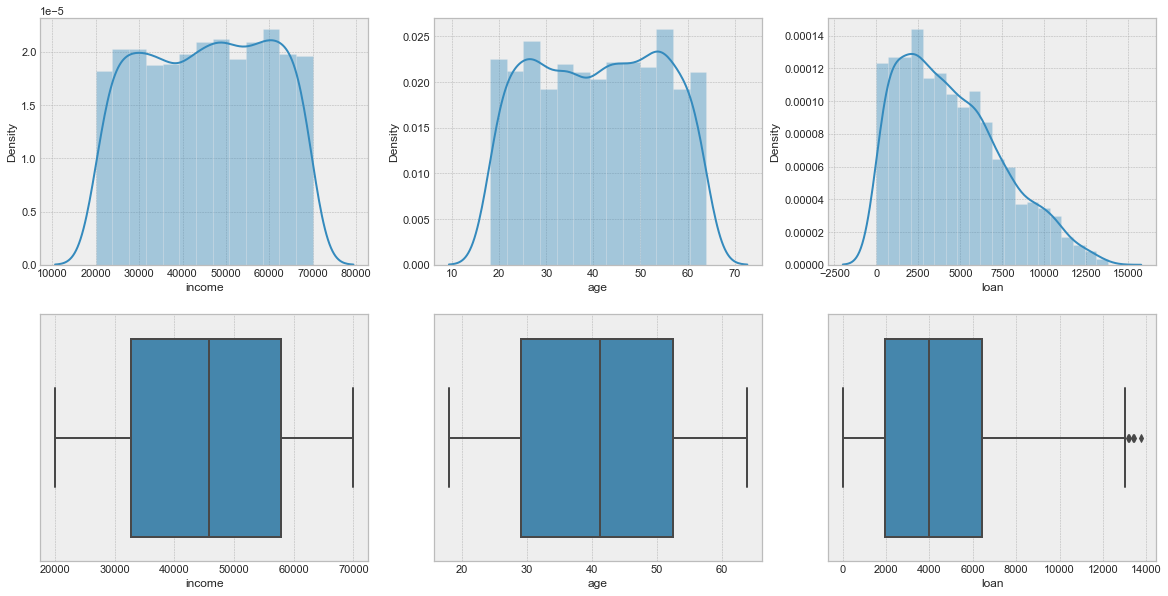

In [19]:
# mount grid 3 rows x 3 cols to receive charts
grid = GridSpec(2, 3)

# Distribution
plt.subplot(grid[0,0])
sns.distplot( df2['income'] )

plt.subplot(grid[0,1])
sns.distplot( df2['age'] )

plt.subplot(grid[0,2])
sns.distplot( df2['loan'] )

# Boxplot
plt.subplot(grid[1,0])
sns.boxplot( x=df2['income'])

plt.subplot(grid[1,1])
sns.boxplot( x=df2['age'] )

plt.subplot(grid[1,2])
sns.boxplot( x=df2['loan'] )

## 2.2 Analysing chart above

#### - We have outliers in the loans.

#### - We have great loans volume below $ 5.000

#### - 75% os loans area less than $ 6.000.

#### - 25% of customers are under 30 years

#### - 50% of customers incomes are over $ 40.000

# 3.0 FEATURE ENGINEERING

In [20]:
df3 = df2.copy()

## 3.1 Mind Map - Which leverages impact the granting of credit

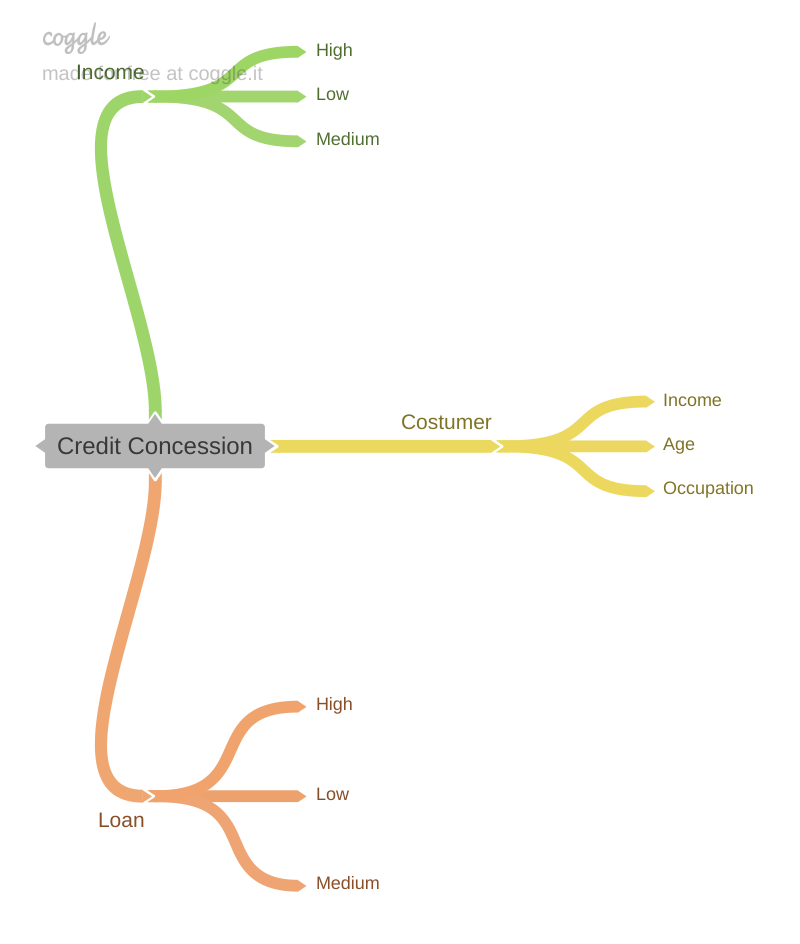

In [21]:
Image("img/Credit_Concession.png")

## 3.2 - Creating Hypotheses to get insigths

### 3.2.1 - Loan Assumptions

**1.** High loan values are more denied.

**2.** Mid Loan are more granted.

**3.** Loans are more applyed in the begining of the year. 

### 3.2.1 - Customers Assumptions

**1.** High age customers apply for more loans.

**2.** Young customers apply for lower loans.

**3.** Mid age customers apply for high loans.

**4.** Customers with higher level of studies apply less loans.

### 3.2.1 - Income Assumptions

**1.** Low income apply for more loans.

**2.** High income apply for high loans values.

**3.** Low income are more denied.

### 3.2.1 - Hypotheses Final List

**1.** High Loan are mode denied.

**2.** Median Loan are more granted.

**3.** High age customers apply for more loans.

**4.** Young customers apply for lower loans.

**5.** Mid age customers apply for high loans.

**6.** Low income apply for more loans.

**7.** High income apply for high loans values.

**8.** Low income are more denied.

## 3.3 - Feature Engineering

In [22]:
# Income
df3['income_type'] = df3['income'].apply(lambda x: 'low' if x<35000 else 'mid' if (x>=35000) & (x<50000) else 'high' ).astype('category')

# Age
df3['age_type'] = df3['age'].apply(lambda x: 'young' if x<=30 else 'mid' if (x>30) & (x<60) else 'high' ).astype('category')

# loan
df3['loan_type'] = df3['loan'].apply(lambda x: 'low' if x<=2000 else 'mid' if (x>2000) & (x<6000) else 'high' ).astype('category')

# 4.0 EXPLORATORY DATA ANALYSIS

In [23]:
df4 = df3.copy()

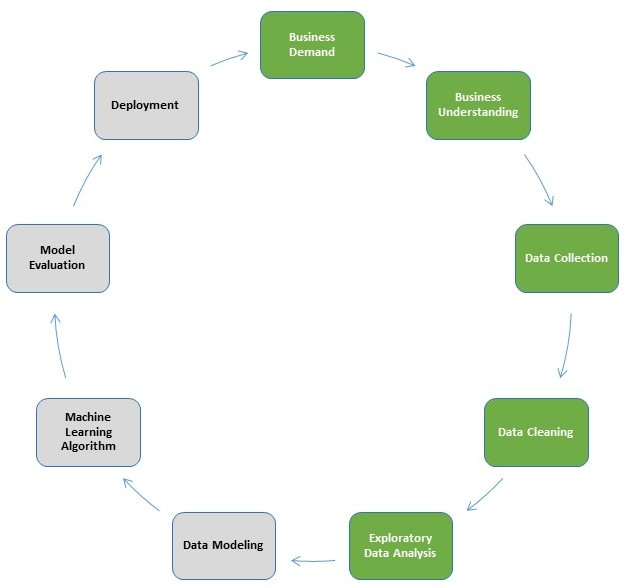

In [24]:
Image("img/crisp4.jpg")

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='c#default', ylabel='Density'>

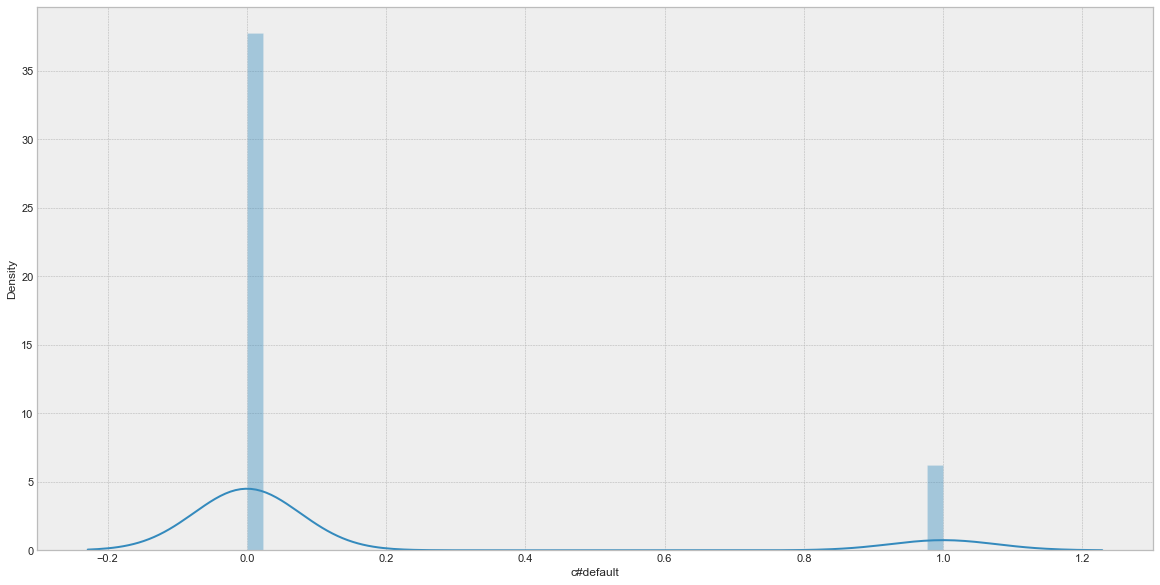

In [25]:
sns.distplot(df4['c#default'])

### 4.1.2 Analysing chart above

#### - We have an imbalanced dataset. We have to balanced the dataset, using undersamplig or oversampling techniques, to get a better model.

### 4.1.3 Numerical Variable

**Histograma**

**Definição:** uma uma representação gráfica em formato de retângulos cuja área é proporcional à frequência de uma variável quantitativa e cuja largura é igual ao intervalo de classe.

**Para que serve:** Um histograma é uma representação gráfica da distribuição de uma variável quantitativa contínua. Com o histograma pode-se visualizar a dispersão/concentração dos dados, bem como a assimetria/simetria dos dados. É muito utilizado para visualizar toda a distribuição de uma variável quantitativa. Foi introduzida pela primeira vez por Karl Pearson (OBS - É muito parecido com o gráfico de barras).

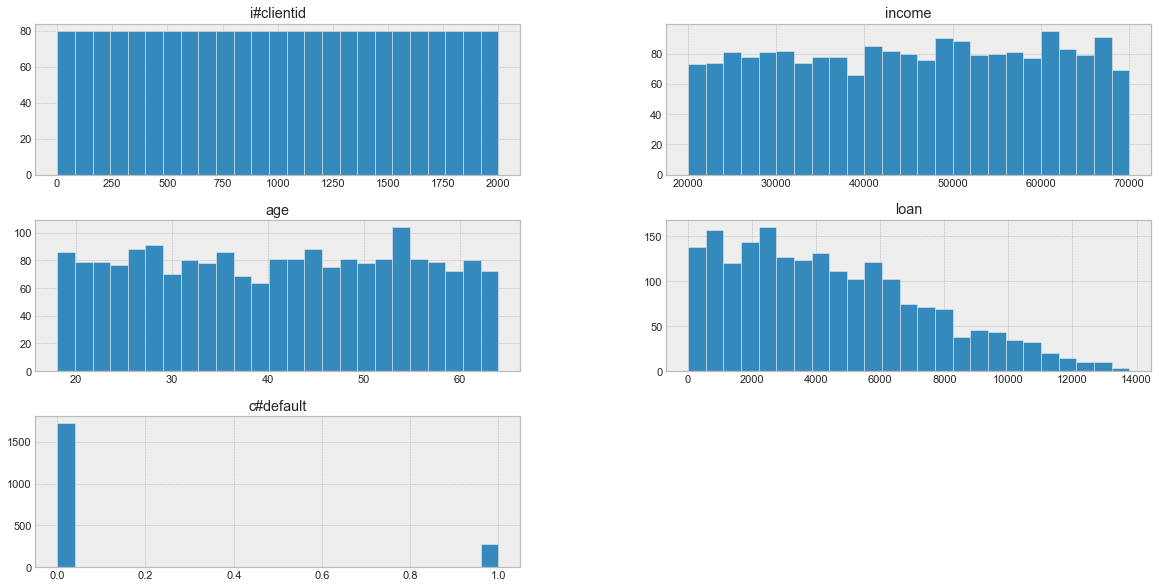

In [26]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an 

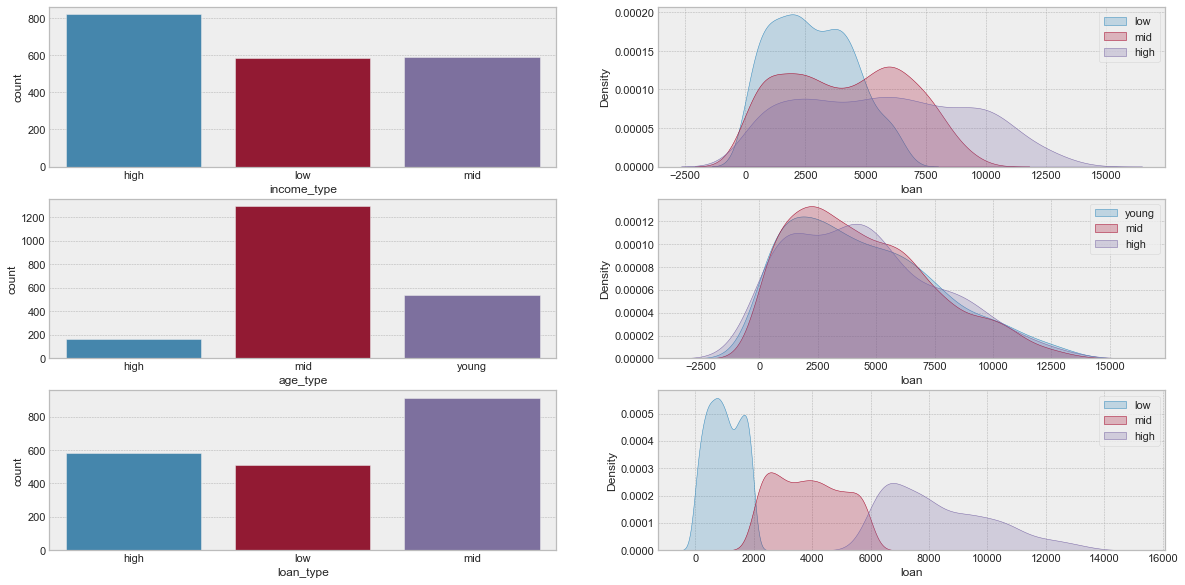

In [27]:
# state_holiday
plt.subplot(3, 2, 1)
sns.countplot(df4['income_type'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['income_type'] == 'low']['loan'], label='low', shade=True) 
sns.kdeplot(df4[df4['income_type'] == 'mid']['loan'], label='mid', shade=True)
sns.kdeplot(df4[df4['income_type'] == 'high']['loan'], label='high', shade=True)
plt.legend()

# age
plt.subplot(3, 2, 3)
sns.countplot(df4['age_type'])
plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['age_type'] == 'young']['loan'], label='young', shade=True) 
sns.kdeplot(df4[df4['age_type'] == 'mid']['loan'], label='mid', shade=True)
sns.kdeplot(df4[df4['age_type'] == 'high']['loan'], label='high', shade=True)
plt.legend()

#loan
plt.subplot(3, 2, 5)
sns.countplot(df4['loan_type'])
plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['loan_type'] == 'low']['loan'], label='low', shade=True, legend=True) 
sns.kdeplot(df4[df4['loan_type'] == 'mid']['loan'], label='mid', shade=True, legend=True)
sns.kdeplot(df4[df4['loan_type'] == 'high']['loan'], label='high', shade=True, legend=True)
plt.legend()

### 4.2 Statistics above

### - Low income loan maximum is $ 7.000

### - High income loan is in a large range of values, fom low to high values.

### - Loan types range is great to cluster customers classes.

## 4.2 Bivariate Analysis

### H1 - High loan values are more denied.

**False**, mid loans is more denied.

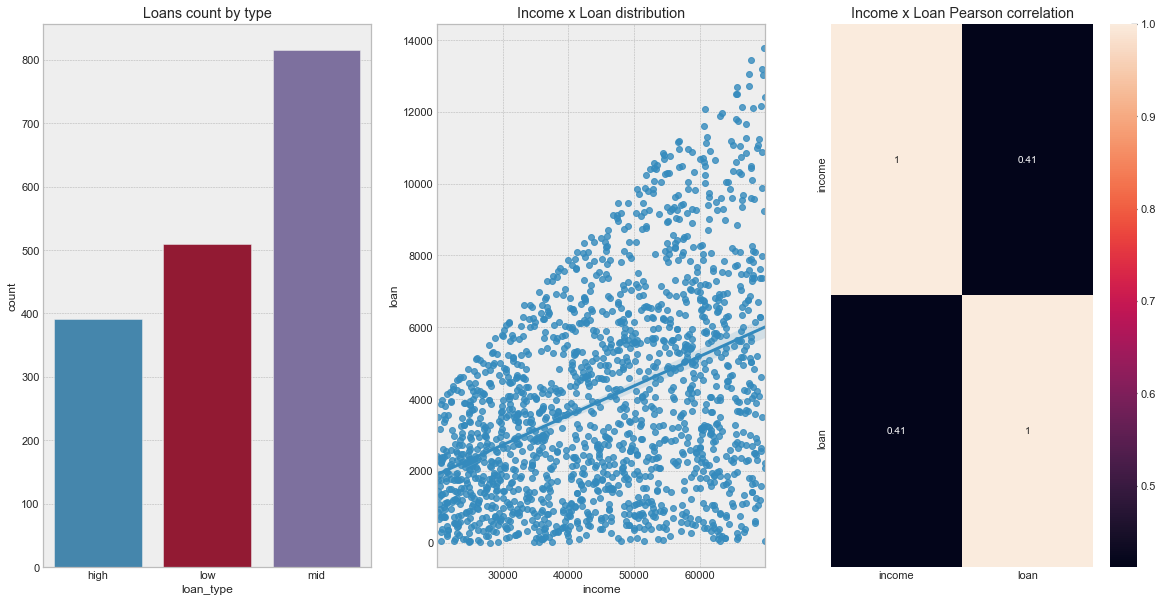

In [28]:
aux = df4[df4['c#default']==0]
aux_corr = aux[['income', 'loan']]
aux_agg = aux[['loan_type']].groupby('loan_type').size().to_frame('count').reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='loan_type', y='count', data=aux_agg).set_title('Loans count by type')

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Income x Loan Pearson correlation');

### H2 - Median Loan are more granted

**False**, High values are more granted.

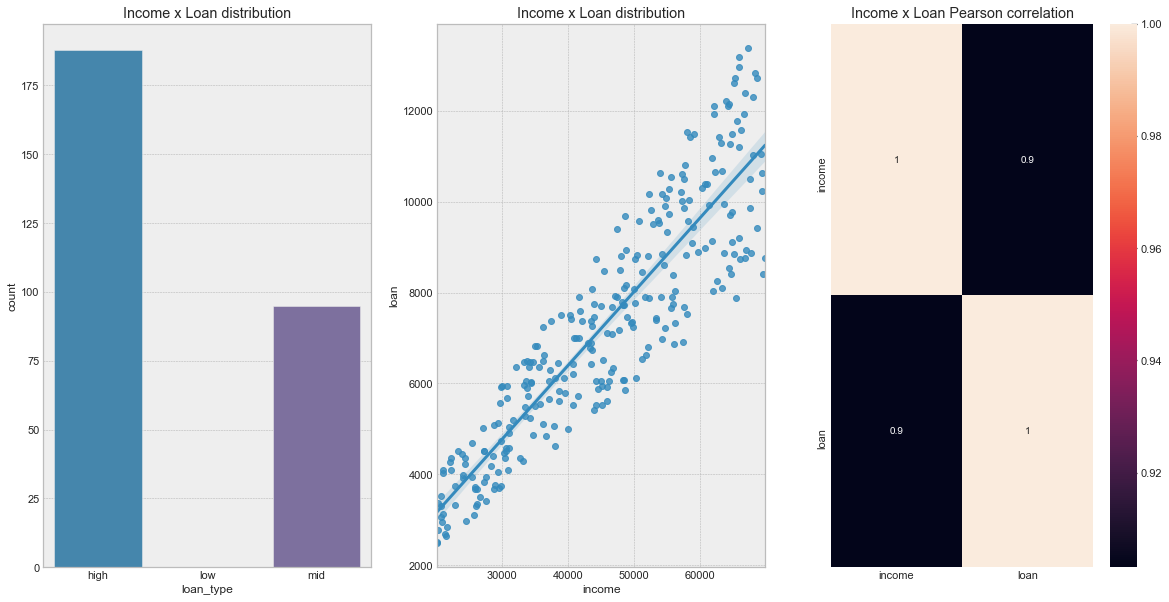

In [29]:
aux = df4[df4['c#default']==1]
aux_corr = aux[['income', 'loan']]
aux_loan_type = aux[['loan_type']].groupby('loan_type').size().to_frame('count').reset_index()

# loan types
plt.subplot(1, 3, 1)
sns.barplot(x='loan_type', y='count', data=aux_loan_type).set_title('Income x Loan distribution');

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Income x Loan Pearson correlation');


### H3 - High age customers apply for more loans.

**False**, mid age apply for more loans.

NameError: name 'aux_age' is not defined

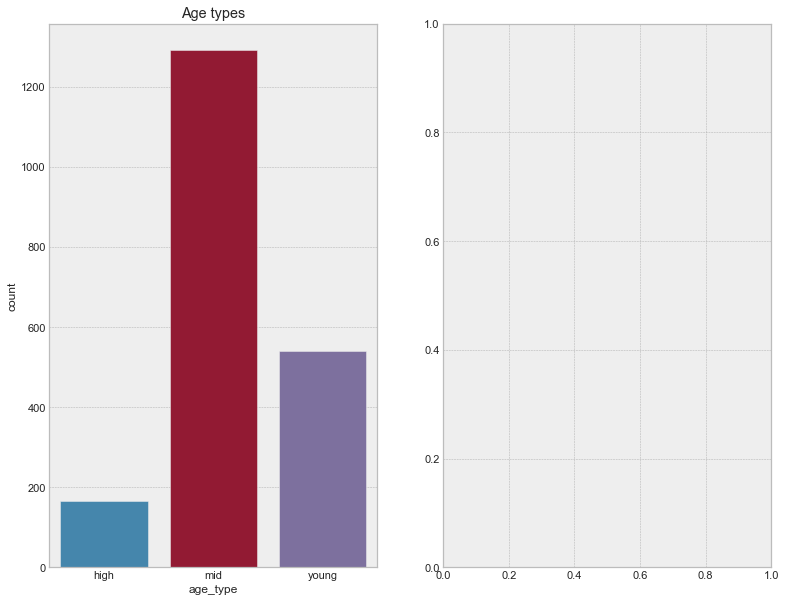

In [30]:
aux = df4[['age_type']].groupby('age_type').size().to_frame('count').reset_index()
aux_corr = df4[['age', 'loan']]

# age types
plt.subplot(1, 3, 1)
sns.barplot(x='age_type', y='count', data=aux).set_title('Age types');

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='age', y='loan', data=aux_age).set_title('Age x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Age x Loan Pearson correlation');


### H4 - Young customers apply for lower loans.

**False**, mid age customers apply for lower loans.

In [ ]:
aux = df4[df4['loan_type']=='low']
aux_agg = aux[['age_type']].groupby(['age_type']).size().to_frame('count').reset_index()
aux_corr = aux[['age', 'loan']]
# age types
plt.subplot(1, 3, 1)
sns.barplot(x='age_type', y='count', data=aux_agg).set_title('Age types');

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='age', y='loan', data=aux_corr).set_title('Age x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Age x Loan Pearson correlation');


### H5 - Mid age customers apply for high loans..

**True**, mid age customers apply for high loans.

In [ ]:
aux = df4[df4['loan_type']=='high']
aux_agg = aux[['age_type']].groupby(['age_type']).size().to_frame('count').reset_index()
aux_corr = aux[['age', 'loan']]

# age types
plt.subplot(1, 3, 1)
sns.barplot(x='age_type', y='count', data=aux_agg).set_title('Age types');

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='age', y='loan', data=aux_corr).set_title('Age x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Age x Loan Pearson correlation');


### H6 - Low income apply for more loans.

**False**, high income apply for more loans.

In [ ]:
aux = df4[['income_type']].groupby('income_type').size().to_frame('count').reset_index()
aux_corr = df4[['age', 'loan']]

# age types
plt.subplot(1, 3, 1)
sns.barplot(x='income_type', y='count', data=aux).set_title('Age types');

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='age', y='loan', data=aux_corr).set_title('Age x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Age x Loan Pearson correlation');


### H7 - High income apply for high loans values.

**True**, high income apply for high loans values.

In [ ]:
aux = df4[df4['loan_type']=='high']
aux_agg = aux[['income_type']].groupby('income_type').size().to_frame('count').reset_index()
aux_corr = aux[['age', 'loan']]

# age types
plt.subplot(1, 3, 1)
sns.barplot(x='income_type', y='count', data=aux_agg).set_title('Age types');

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='age', y='loan', data=aux_corr).set_title('Age x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Age x Loan Pearson correlation');


### H8 - Low income are mode denied.

**False**, high incomes are more denied.

In [ ]:
aux = df4[df4['c#default']==0]
aux.head()
aux_agg = aux[['income_type']].groupby('income_type').size().to_frame('count').reset_index()
aux_corr = aux[['age', 'loan']]
aux_agg.head()

# age types
plt.subplot(1, 3, 1)
sns.barplot(x='income_type', y='count', data=aux_agg).set_title('Age types');

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='age', y='loan', data=aux_corr).set_title('Age x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Age x Loan Pearson correlation');


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

In [ ]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

In [ ]:
df4.dtypes

### 4.3.2 Categorical Attributes

In [ ]:
# only Categorical Attributes
a = df4.select_dtypes( include='category')

# Calculate Cramer_V
a1 = cramer_v(a['age_type'], a['age_type'])
a2 = cramer_v(a['age_type'], a['income_type'])
a3 = cramer_v(a['age_type'], a['loan_type'])

a4 = cramer_v(a['income_type'], a['age_type'])
a5 = cramer_v(a['income_type'], a['income_type'])
a6 = cramer_v(a['income_type'], a['loan_type'])

a7 = cramer_v(a['loan_type'], a['age_type'])
a8 = cramer_v(a['loan_type'], a['income_type'])
a9 = cramer_v(a['loan_type'], a['loan_type'])

# Final Dataset
d = pd.DataFrame({'age_type': [a1, a2, a3],
                 'income_type': [a4, a5, a6],
                 'loan_type': [a7, a8, a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True);


## 4.4 Benford´s Law Analysis

### 4.4.1 Create Benford´s Distribution

In [295]:
data = { 'digits': [1, 2, 3, 4, 5, 6, 7, 8, 9] }
df_benford = pd.DataFrame(data, dtype=np.int8)
df_benford['benford_proportion'] = df_benford['digits'].apply( lambda x: math.log10( 1+1/x ) )

### 4.4.2 Income analysis using Benford´s Law

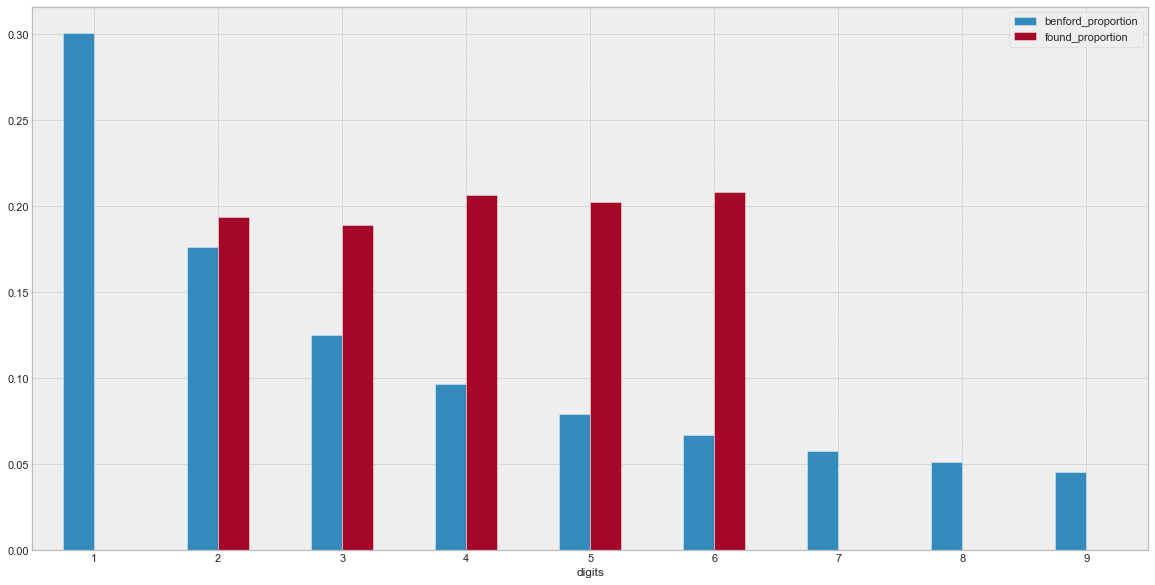

In [307]:
df_income = df5['income'].astype(str).str[0].to_frame('digits').astype(int8)
df_income = df_income.groupby('digits').size().to_frame('found_frequency').reset_index()
df_income['found_proportion'] = df_income['found_frequency']/df_income['found_frequency'].sum()

# merge
df_benford_analysis = pd.merge( df_benford, df_income, how='left', on='digits')

# replace NaN
df_benford_analysis['found_frequency'] = df_benford_analysis['found_frequency'].fillna(0)
df_benford_analysis['found_proportion'] = df_benford_analysis['found_proportion'].fillna(0)

# calculating conformity testing
#df_income['median_absolute_deviation'] = mad( df_income['found_proportion', 'benford_proportion'] )

df_benford_analysis.head(10)
ax = df_benford_analysis.plot.bar(x='digits', y=['benford_proportion', 'found_proportion'], rot=0)

### 4.4.3 Loan analysis using Benford´s Law

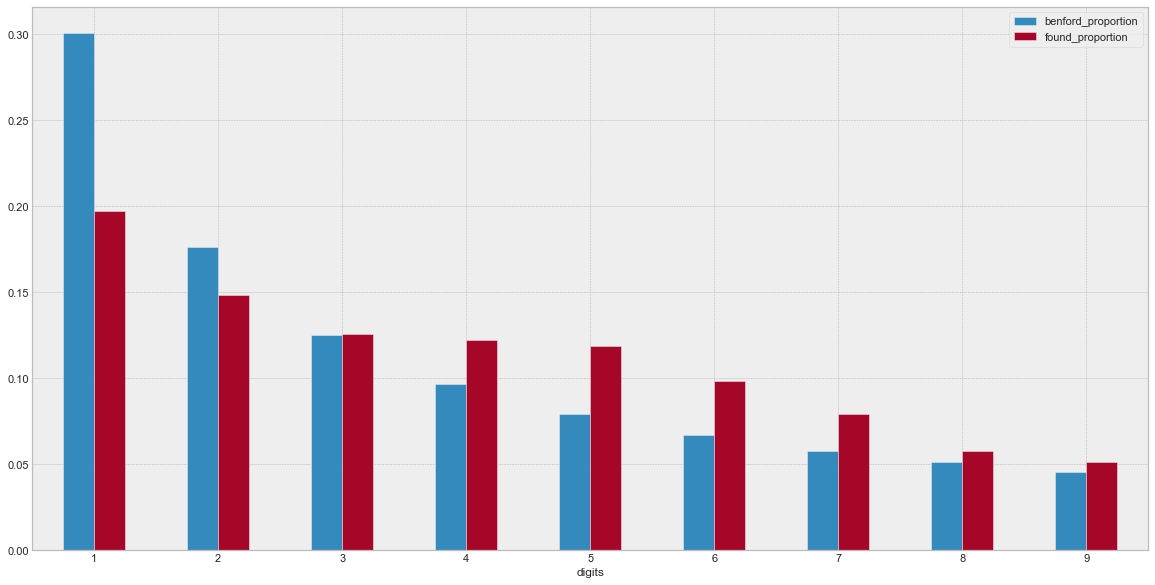

In [276]:
df_loan = df5['loan'].astype(str).str[0].to_frame('digits').astype(int8)
df_loan = df_loan.groupby('digits').size().to_frame('found_frequency').reset_index()
df_loan['found_proportion'] = df_loan['found_frequency']/df_loan['found_frequency'].sum()

# merge
df_benford_analysis = pd.merge( df_benford, df_loan, how='left', on='digits')

# replace NaN
df_benford_analysis['found_frequency'] = df_benford_analysis['found_frequency'].fillna(0)
df_benford_analysis['found_proportion'] = df_benford_analysis['found_proportion'].fillna(0)

df_benford_analysis.head(10)
ax = df_benford_analysis.plot.bar(x='digits', y=['benford_proportion', 'found_proportion'], rot=0)

# 5.0 DATA PREPARATION



In [319]:
df5=df4.copy()

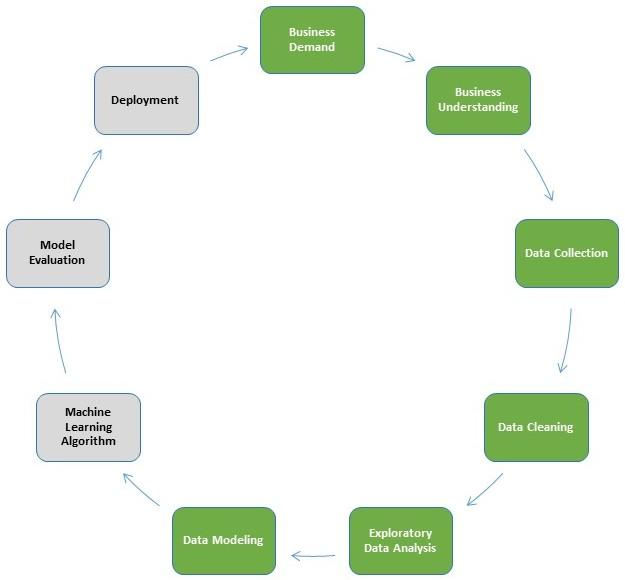

In [320]:
Image("img/crisp5.jpg")

## 5.1 Transformation

### 5.1.1 Encoding

In [321]:
df5['loan_type'].unique()

['high', 'low', 'mid']
Categories (3, object): ['high', 'low', 'mid']

In [322]:
# we´ll use a dict to associate the category with its hierarchy

ordinal_dict = { 'low':1, 'mid':2, 'high':3 }
df5['income_type'] = df5['income_type'].map( ordinal_dict ).astype('int8')
df5['loan_type'] = df5['loan_type'].map( ordinal_dict ).astype('int8')

ordinal_dict = { 'young':1, 'mid':2, 'high':3 }
df5['age_type'] = df5['age_type'].map( ordinal_dict ).astype('int8')

### 5.1.3 Split dataframe into predictors and target variable 


In [323]:
# create predicts variables
cols_drop = ['i#clientid', 'c#default']
X = df5.drop( cols_drop, axis=1).values # create list to predictors variables

# target variable
y = df5.iloc[:, 4].values # create list to target variable

## 5.2 Split dataframe into training and test

**It´s very important to separate dataset in training and test before the escale transformation. Test data is like future data and should not contaminate training data.**

In [479]:
# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

#build training test dataframe
df_train =pd.DataFrame(X_train,columns   = ['income', 'age', 'loan', 'income_type', 'age_type', 'loan_type'])
df_test = pd.DataFrame(X_test,columns    = ['income', 'age', 'loan', 'income_type', 'age_type', 'loan_type'])
df_y_train =pd.DataFrame(y_train,columns = ['c#default'])


## 5.3 Normalization

**Used when we have a normal data distribution.**

## 5.4 Rescaling only training dataset

**- Min-Max Scaler (Sensível a Outlier)**

**- Robust Scaler**

C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an 

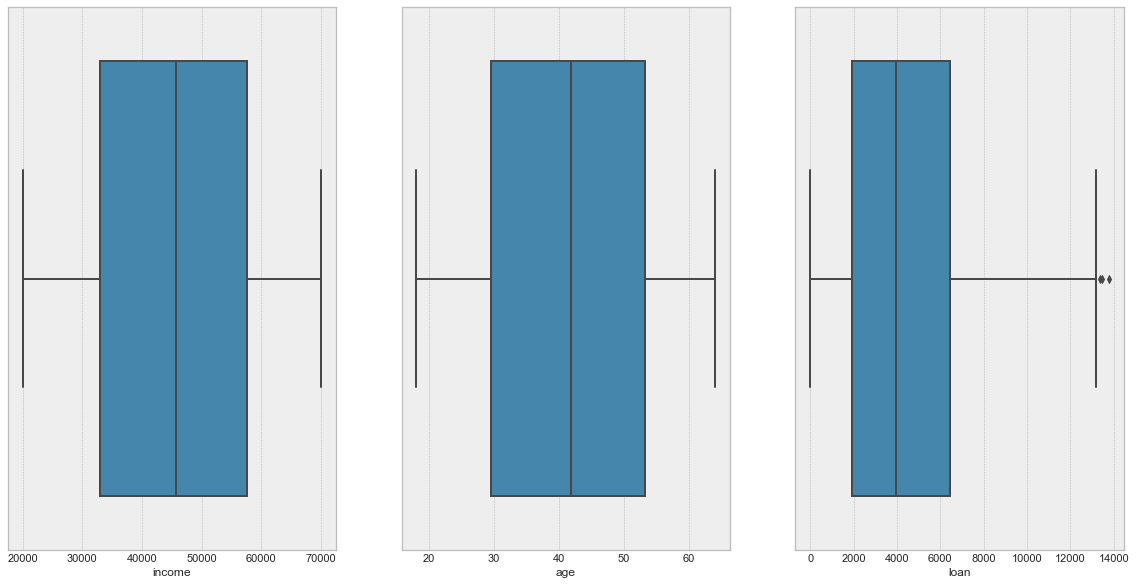

In [325]:
# Identificando Outliers
plt.subplot(1,3,1)
sns.boxplot( df_train['income']);

plt.subplot(1,3,2)
sns.boxplot( df_train['age']);

plt.subplot(1,3,3)
sns.boxplot( df_train['loan']);

In [326]:
rs = RobustScaler()
mms = MinMaxScaler()

# Aplica RobustScaler nas variáveis com Outliers

# loan
df_train['loan'] = rs.fit_transform(df_train[['loan']].values)
pickle.dump( rs, open('parameter/loan_scaler.pkl', 'wb'))

# Aplica MinMaxScaler nas variáveis sem Outliers

# income
df_train['income'] = mms.fit_transform(df_train[['income']].values)
pickle.dump( rs, open('parameter/income_scaler.pkl', 'wb'))
                                               
# age
df_train['age'] = mms.fit_transform(df_train[['age']].values)
pickle.dump( rs, open('parameter/age_scaler.pkl', 'wb'))

## 5.5 Balancing Dataset

Class distribution
0    1717
1     283
Name: c#default, dtype: int64


(2772, 6)

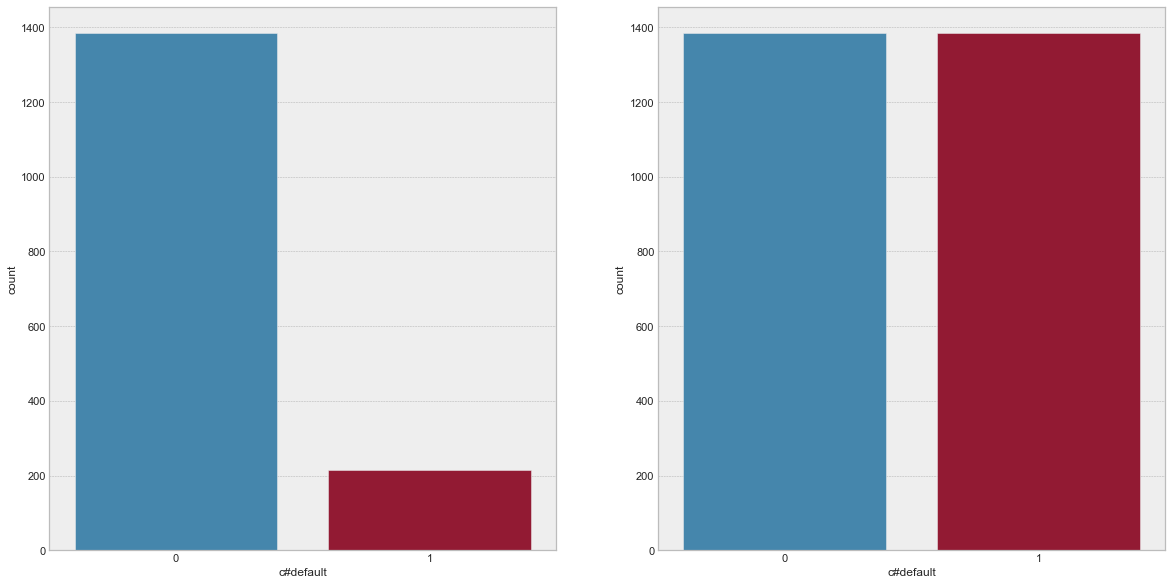

In [497]:
print('Class distribution\n{}'.format(df5['c#default'].value_counts()))

plt.subplot(1,2,1)
sns.countplot(x='c#default', data=df_y_train);

smt = SMOTE(sampling_strategy='auto')
X_df_train_resampled, y_df_train_resampled = smt.fit_sample(df_train, df_y_train)

plt.subplot(1,2,2)
sns.countplot(x='c#default', data=y_df_train_resampled);

X_resampled.shape

# 6.0 FEATURE SELECTION

## 6.1 Boruta as Feature Selector

In [499]:
# training and teste dataset for Boruta
X_train_boruta = X_df_train_resampled.values
y_train_boruta = y_df_train_resampled.values.ravel()

#define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_boruta, y_train_boruta)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	1
Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	1
Iteration: 	10 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	1
Iteration: 	11 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	1
Iteration: 	12 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	1
Iteration: 	13 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	1
Iteration: 	14 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	1
Iteration: 	15 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	1
Iteration: 	16 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	2


BorutaPy finish

## 6.2 Best feature from Boruta

In [500]:
# Best features
cols_selected_boruta = boruta.support_.tolist()
cols_selected_boruta = df_train.iloc[:, cols_selected_boruta].columns.to_list()

# ignored by boruta
cols_ignored_boruta = list(np.setdiff1d(df_train.columns, cols_selected_boruta))

print(cols_selected_boruta, cols_ignored_boruta)

['income', 'age', 'loan', 'loan_type'] ['age_type', 'income_type']


# 7.0 MACHINE LEARNING MODELLING

![Crisp 6](img/crisp6.jpg)

## 7.1 Naive Bayes Classifier  

In [521]:
nb = GaussianNB()
nb_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled.values.ravel(), 'Naive Bayes Classifier', nb, 10, 100, verbose=False)

Confusion matrix:
[[121.691  16.909]
 [ 10.237 128.363]]

              precision    recall  f1-score   support

           0     0.9237    0.8768    0.8996       138
           1     0.8836    0.9281    0.9053       139

    accuracy                         0.9025       277
   macro avg     0.9036    0.9024    0.9024       277
weighted avg     0.9035    0.9025    0.9025       277



## 7.2 Decision Tree Classifier  

In [522]:
dtc = DecisionTreeClassifier()
dtc_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled.values.ravel(), 'DecisionTreeClassifier', dtc, 10, 100, verbose=False)

Confusion matrix:
[[137.042   1.558]
 [  0.798 137.802]]

              precision    recall  f1-score   support

           0     0.9926    0.9710    0.9817       138
           1     0.9718    0.9928    0.9822       139

    accuracy                         0.9819       277
   macro avg     0.9822    0.9819    0.9819       277
weighted avg     0.9822    0.9819    0.9819       277



## 7.3 KNN Classifier  

In [503]:
knn = KNeighborsClassifier()
knn_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled.values.ravel(), 'KNN Classifier', knn, 10, 100, verbose=False)

Confusion matrix:
[[110.294  28.306]
 [  4.293 134.307]]



## 7.4 LogisticRegression Classifier

In [504]:
lr = LogisticRegression()
lr_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled.values.ravel(), 'LogisticRegression Classifier', lr, 10, 100, verbose=False)

C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

Confusion matrix:
[[124.972  13.628]
 [ 17.378 121.222]]



## 7.5 Support Vector Machine Classifier

In [505]:
svm = SVC()
svm_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled.values.ravel(), 'SVM Classifier', svm, 10, 100, verbose=False)

Confusion matrix:
[[ 94.283  44.317]
 [  0.179 138.421]]



## 7.6 Neural Network Classifier

In [506]:
mlp = MLPClassifier(verbose=False)
mlp_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled.values.ravel(), 'NeuralNertwork Classifier', mlp, 10, 100, verbose=False)

Confusion matrix:
[[107.49  31.11]
 [ 33.54 105.06]]



## 7.7 Keras/Tensorflow Neural Network Classifier

In [508]:
KerasClassifier = Sequential()
# 1st layer
KerasClassifier.add( Dense(units=6, # neurons
                 activation='relu',
                 input_dim=6) )
# 2nd layer
KerasClassifier.add( Dense(units=6, # neurons
                 activation='relu') )

# out layer
KerasClassifier.add( Dense(units=1, # neurons
                 activation='sigmoid') )

#  compile neural network
KerasClassifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

n_repeats = 10
n_splits  = 10
epochs    = 100
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=0)
i = 1
conf_matrix = []
accuracy = []

xtrain = X_df_train_resampled.values
ytrain = y_df_train_resampled.values.ravel()

for train_idx, validation_idx in rskf.split(xtrain, ytrain ): #np.zeros(shape=(X_train.shape[0], 1))
    print( 'Running {}/{}'.format(i, n_repeats*n_splits) )
    i += 1
    KerasClassifier.fit(xtrain[train_idx], ytrain[train_idx], batch_size=100, epochs=epochs, verbose=False)
    
    # predicting
    prediction = KerasClassifier.predict(xtrain[validation_idx])
    prediction = (prediction>0.5)
    score = accuracy_score(ytrain[validation_idx], prediction)
    cnf_matrix = confusion_matrix(ytrain[validation_idx], prediction)
    conf_matrix.append( cnf_matrix ) 
    accuracy.append(score)
    #udf_cross_validation(df_train, y_train, 'Keras/Tensorflow', KerasClassifier, 10, 100, verbose=False)


print('\nConfusion matrix:\n{}\n'.format(np.mean(conf_matrix, axis=0)))
        
keras_result_cv = pd.DataFrame(
    {
        'Model Name'       : 'Keras/Tensorflow',
        'Accuracy_score'   : np.round( np.mean(accuracy), 2 ).astype(str)
    },
    index=[0]
)

Running 1/100
Running 2/100
Running 3/100
Running 4/100
Running 5/100
Running 6/100
Running 7/100
Running 8/100
Running 9/100
Running 10/100
Running 11/100
Running 12/100
Running 13/100
Running 14/100
Running 15/100
Running 16/100
Running 17/100
Running 18/100
Running 19/100
Running 20/100
Running 21/100
Running 22/100
Running 23/100
Running 24/100
Running 25/100
Running 26/100
Running 27/100
Running 28/100
Running 29/100
Running 30/100
Running 31/100
Running 32/100
Running 33/100
Running 34/100
Running 35/100
Running 36/100
Running 37/100
Running 38/100
Running 39/100
Running 40/100
Running 41/100
Running 42/100
Running 43/100
Running 44/100
Running 45/100
Running 46/100
Running 47/100
Running 48/100
Running 49/100
Running 50/100
Running 51/100
Running 52/100
Running 53/100
Running 54/100
Running 55/100
Running 56/100
Running 57/100
Running 58/100
Running 59/100
Running 60/100
Running 61/100
Running 62/100
Running 63/100
Running 64/100
Running 65/100
Running 66/100
Running 67/100
Runn

## 7.8 Random Forest Classifier

In [509]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
rf_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled.values.ravel(), 'Random Forest Classifier', rf, 10, 100, verbose=False)

Confusion matrix:
[[136.637   1.963]
 [  0.539 138.061]]



## 7.9 XGBoost Classifier

In [524]:
xgb_model = XGBClassifier(n_jobs=-1, subsample=1.0, n_estimators=210, min_samples_split=32, min_samples_leaf=22, max_features=13, max_depth=85, learning_rate=0.11800000000000001)
xgb_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled.values.ravel(), 'XGBoost Classifier', xgb_model, 10, 100, verbose=False)

Confusion matrix:
[[137.376   1.224]
 [  0.405 138.195]]

              precision    recall  f1-score   support

           0     0.9926    0.9783    0.9854       138
           1     0.9787    0.9928    0.9857       139

    accuracy                         0.9856       277
   macro avg     0.9857    0.9855    0.9856       277
weighted avg     0.9857    0.9856    0.9856       277



## 7.10 XGBoostRF Classifier

In [511]:
xgbrf_model = XGBRFClassifier(n_jobs=-1, subsample=1.0, n_estimators=210, min_samples_split=32, min_samples_leaf=22, max_features=13, max_depth=85, learning_rate=0.11800000000000001)
xgbrf_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled.values.ravel(), 'XGBoostRF Classifier', xgbrf_model, 10, 100, verbose=False)

Confusion matrix:
[[135.137   3.463]
 [  1.157 137.443]]



## 7.11 Real Model´s Performance

In [523]:
model_result_cv = pd.concat([nb_result_cv, dtc_result_cv, knn_result_cv, lr_result_cv, svm_result_cv, mlp_result_cv, keras_result_cv, xgb_result_cv, xgbrf_result_cv]) 
model_result_cv.sort_values('Accuracy_score',  ascending=False)

,Model Name,Accuracy_score
0,DecisionTreeClassifier,0.99
0,XGBoost Classifier,0.99
0,XGBoostRF Classifier,0.98
0,Keras/Tensorflow,0.92
0,Naive Bayes Classifier,0.9
0,LogisticRegression Classifier,0.89
0,KNN Classifier,0.88
0,SVM Classifier,0.84
0,NeuralNertwork Classifier,0.77


# 8.0 HYPERPARAMETER FINE TUNNING

## 8.1 Random Search

In [534]:
# criação de parâmetros
n_estimators      =  list(range(10,201,10)) # numeros de arvores
eta               = np.arange(0.01, 0.10, 0.01).tolist()
max_depth         = list(range(5,101,5))
subsample         = np.arange(0.01, 0.10, 0.01).tolist()
min_samples_split = list(range(2,41,2))
min_samples_leaf  = list(range(2,41,2))
colsample_bytee   = np.arange(0.1, 1, 0.1).tolist()
min_child_weight  = list(range(1,15,1))

param = {'n_estimators'      : n_estimators,
         'eta'               : eta,
         'max_depth'         : max_depth,
         'subsample'         : subsample,
         'min_samples_split' : min_samples_split,
         'min_samples_leaf'  : min_samples_leaf,
         'colsample_bytee'   : colsample_bytee,
         'min_child_weight'  : min_child_weight
        }

# executando o fine tunning
MAX_EVAL = 2
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    # choose values for parameters randomly
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print(hp)
    # model
    model_xgb = XGBClassifier(objective='reg:squarederror',
                              n_estimators     = hp['n_estimators'],
                              eta              = hp['eta'],
                              max_depth        = hp['max_depth'],
                              subsample        = hp['subsample'],
                              colsample_bytee  = hp['colsample_bytee'],
                              min_child_weight = hp['min_child_weight'])
    
    # performance
    xgb_result_rscv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled.values.ravel(), 'XGBoost Classifier', xgb_model, 10, 100, verbose=False)
    final_result = pd.concat( [final_result, xgb_result_rscv] )

final_result

{'n_estimators': 10, 'eta': 0.09, 'max_depth': 55, 'subsample': 0.02, 'min_samples_split': 10, 'min_samples_leaf': 24, 'colsample_bytee': 0.1, 'min_child_weight': 13}
Confusion matrix:
[[137.376   1.224]
 [  0.405 138.195]]

              precision    recall  f1-score   support

           0     0.9926    0.9783    0.9854       138
           1     0.9787    0.9928    0.9857       139

    accuracy                         0.9856       277
   macro avg     0.9857    0.9855    0.9856       277
weighted avg     0.9857    0.9856    0.9856       277

{'n_estimators': 200, 'eta': 0.06999999999999999, 'max_depth': 50, 'subsample': 0.08, 'min_samples_split': 32, 'min_samples_leaf': 18, 'colsample_bytee': 0.30000000000000004, 'min_child_weight': 1}
Confusion matrix:
[[137.376   1.224]
 [  0.405 138.195]]

              precision    recall  f1-score   support

           0     0.9926    0.9783    0.9854       138
           1     0.9787    0.9928    0.9857       139

    accuracy                

,Model Name,Accuracy_score
0,XGBoost Classifier,0.99
0,XGBoost Classifier,0.99


## 8.2 Final Model

In [647]:
param_tuned = {'n_estimators'      : 110,
               'eta'               : 0.05,
               'max_depth'         : 50,
               'subsample'         : 0.08,
               'min_samples_split' : 18,
               'min_samples_leaf'  : 10,
               'colsample_bytee'   : 0.1,
               'min_child_weight'  : 12
              }

# model
X_train_tuned = df_train.values
model_xgb_tuned = XGBClassifier(objective='reg:squarederror',
                                n_estimators     = param_tuned['n_estimators'],
                                eta              = param_tuned['eta'],
                                max_depth        = param_tuned['max_depth'],
                                subsample        = param_tuned['subsample'],
                                colsample_bytee  = param_tuned['colsample_bytee'],
                                min_child_weight = param_tuned['min_child_weight'])
#model_xgb_tuned.fit(X_train_tuned, y_train)
model_xgb_tuned.fit(X_df_train_resampled.values, y_df_train_resampled.values.ravel())

# prediction
y_pred_tuned = model_xgb_tuned.predict(X_test)

score = accuracy_score(y_test, y_pred_tuned)
conf_matrix = confusion_matrix(y_test, y_pred_tuned)
classification_dict = classification_report(y_test, y_pred_tuned, digits=4, output_dict=True)

print( 'Confusion matrix:\n{}\n'.format(conf_matrix) )
print( classification_report( y_test, y_pred_tuned, digits=4) )

df_predict    = pd.DataFrame( X_test,columns   = ['income', 'age', 'loan', 'income_type', 'age_type', 'loan_type'] )
df_y_predict = pd.DataFrame( y_pred_tuned, columns   = ['prediction'] )
df_predict['prediction'] = df_y_predict['prediction']

pd.DataFrame(
    {
        'Model Name'       : 'XGBClassifier',
        'Accuracy_score'   : np.round( np.mean(accuracy), 2 ).astype(str)
    },
    index=[0]
)

Confusion matrix:
[[322   9]
 [  5  64]]

              precision    recall  f1-score   support

           0     0.9847    0.9728    0.9787       331
           1     0.8767    0.9275    0.9014        69

    accuracy                         0.9650       400
   macro avg     0.9307    0.9502    0.9401       400
weighted avg     0.9661    0.9650    0.9654       400



,Model Name,Accuracy_score
0,XGBClassifier,0.92


# 9.0 MODEL TRANSLATION AND INTERPRETATION

In [659]:
# get precision per target
data = { 'prediction' : [0, 1], 'precision':[classification_dict.get('0').get('precision'), classification_dict.get('1').get('precision')] }
df_precision = pd.DataFrame(data)
df_precision.head()

predict_agg_sum   = df_predict[['prediction', 'loan']].groupby('prediction').sum().reset_index()
predict_agg_count = df_predict[['prediction', 'loan']].groupby('prediction').size().to_frame('customers_count').reset_index()

predict_agg_count.head()

# join dataframes
df_predict_agg = pd.merge(predict_agg_sum, predict_agg_count, how='left', on='prediction')
df_predict_agg = pd.merge(df_predict_agg, df_precision, how='left', on='prediction')
df_predict_agg['customers_percent'] = df_predict_agg['customers_count']/df_predict_agg['customers_count'].sum()*100.00
df_predict_agg['warranted_values']  = np.round(df_predict_agg['loan'] * df_predict_agg['precision'], 2)
df_predict_agg['loss_margin']       = df_predict_agg['loan'] * (1-df_predict_agg['precision'])

# format values
df_predict_agg['loan']  = df_predict_agg['loan'].map( 'R$ {:,.2f}'.format )
df_predict_agg['warranted_values']  = df_predict_agg['warranted_values'].map( 'R$ {:,.2f}'.format )
df_predict_agg['loss_margin']       = df_predict_agg['loss_margin'].map( 'R$ {:,.2f}'.format )

predict_map = {0:'will pay', 1:'won´t pay'}
df_predict_agg['prediction'] = df_predict_agg['prediction'].map(predict_map)

df_predict_agg.head()

,prediction,loan,customers_count,precision,customers_percent,warranted_values,loss_margin
0,will pay,"R$ 1,307,784.00",327,0.984709,81.75,"R$ 1,287,787.30","R$ 19,996.70"
1,won´t pay,"R$ 534,936.00",73,0.876712,18.25,"R$ 468,984.99","R$ 65,951.01"
